# Inferring a complex nonlinear feature space

In [2]:
# Load General Modules
%matplotlib inline
import matplotlib
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
from scipy.stats import chi
import scipy as sp
from scipy import signal
from sklearn import linear_model
import pickle
import datetime
import time
import os
%load_ext autoreload
%autoreload 2

# Local modules (scripts need to be in folder)
import sys
my_path = '/gpfs01/bethge/home/dklindt/David/publish'
sys.path.append(my_path)

import CNN
import generate_neurons
import generate_data
import pre_process
import GLMs
import training

# Tensorflow needs to be LAST import
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


1.0.0


## Loading data from VGG Conv2 activations

In [2]:
#
Data=np.load('/gpfs01/bethge/home/dklindt/David/publish/data.npz')
print(Data.keys())
Y=Data.f.responses
Y=Y.T# N x D
X=Data.f.images# D x 3 x 44 x 44
X=np.transpose(X,axes=[0,3,1,2])# NCHW
loc_y=Data.f.loc_y
loc_x=Data.f.loc_x
feature_maps=Data.f.feature_maps

['images', 'responses', 'loc_y', 'loc_x', 'feature_maps']


## Train - Val - Split

In [3]:
# splits data into train,val,test and adds poisson-like noise
def splitting_data(X,Y,num_train,num_val,num_test=2**10,noise=True,mean_response=.1):
    
    N=Y.shape[0]#number of neurons
    
    X_train=X[:num_train,:,:,:]
    X_val=X[num_train:num_train+num_val,:,:,:]
    X_test=X[num_train+num_val:num_train+num_val+num_test,:,:,:]
    
    Y_train=np.zeros([N,num_train])
    Y_val=np.zeros([N,num_val])
    #Y_test=np.zeros([N,num_test])
    GT_test=np.zeros([N,num_test])
    
    for n in range(1000):
        tmp_mean = np.mean(Y[n,:])
        Y_train[n,:] = Y[n,:num_train] / tmp_mean * mean_response
        Y_val[n,:] = Y[n,num_train:num_train+num_val] / tmp_mean * mean_response
        GT_test[n,:] = Y[n,num_train+num_val:num_train+num_val+num_test] / tmp_mean * mean_response
    
    #Poisson-like noise
    if noise:
        Y_train += np.random.normal(0,np.sqrt(np.abs(Y_train)),Y_train.shape)
        Y_val +=  np.random.normal(0,np.sqrt(np.abs(Y_val)),Y_val.shape)
        #Y_test =  GT_test + np.random.normal(0,np.sqrt(np.abs(GT_test)),GT_test.shape)
    
    #Poisson noise
    #if noise:
    #    Y_train += np.random.poisson(Y_train)
    #    Y_val +=  np.random.poisson(Y_val)
    #    Y_test =  GT_test + np.random.poisson(GT_test)
    
    return Y_train,Y_val,X_train,X_val,X_test,GT_test#,Y_test

## Explore! Try fitting with different parameter settings

Images for Training: 28672, Validation: 4096, Testing 1024
it took 8.812963247299194 s to preprocess data
Before Training:
Total FEV =  -0.0498243920733
Loss/Regularization: 0.0817481633276 MSE, 0.0 kernel, 0.0907736778259 mask, 0.000100063502789 weights


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


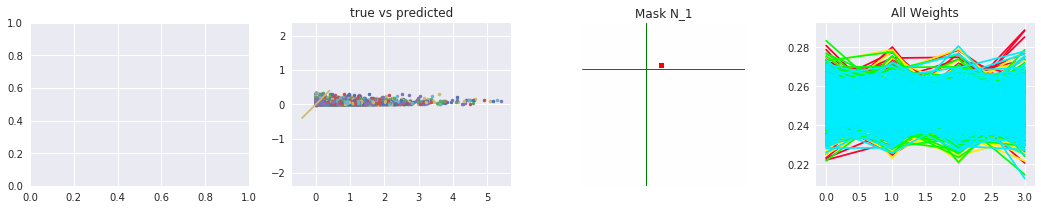

Total FEV =  -0.0130181092866
Runs: 100; MSE - train: 0.15902, val: 0.180130003951; lr = 0.001
best run:  100 0.180130003951
Loss/Regularization: 0.0788821163587 MSE, 0.0 kernel, 0.0624126255512 mask, 8.51131677628e-05 weights


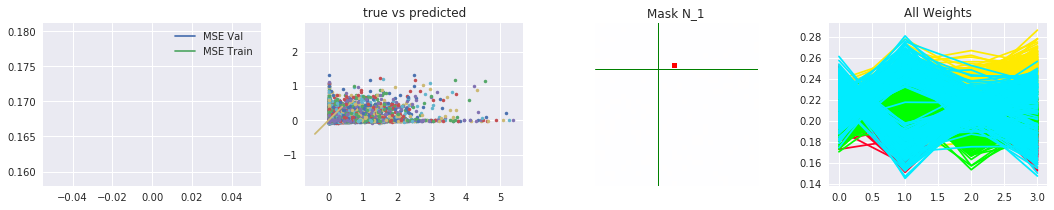

Total FEV =  0.196536394607
Runs: 200; MSE - train: 0.176955, val: 0.162846640917; lr = 0.001
best run:  200 0.162846640917
Loss/Regularization: 0.0625644389074 MSE, 0.0 kernel, 0.0548332631588 mask, 7.09007441998e-05 weights


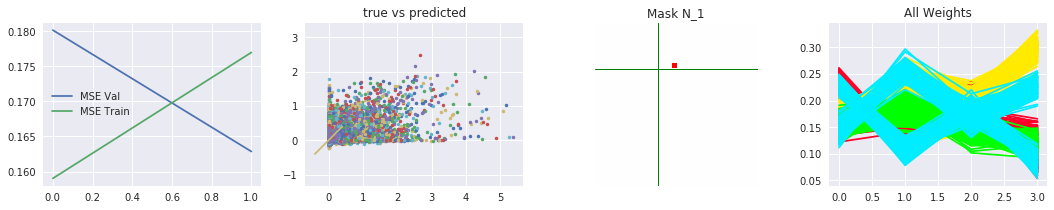

Total FEV =  0.327671133052
Runs: 300; MSE - train: 0.143017, val: 0.152291561011; lr = 0.001
best run:  300 0.152291561011
Loss/Regularization: 0.0523531844374 MSE, 0.0 kernel, 0.052329325676 mask, 6.12144768238e-05 weights


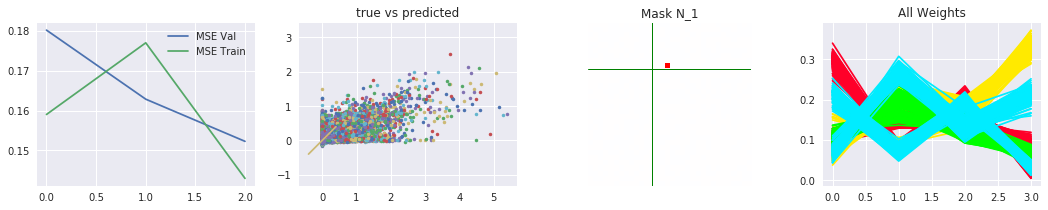

Total FEV =  0.387826483578
Runs: 400; MSE - train: 0.13609, val: 0.147781530977; lr = 0.001
best run:  400 0.147781530977
Loss/Regularization: 0.04766898253 MSE, 0.0 kernel, 0.0506986439228 mask, 5.4983150959e-05 weights


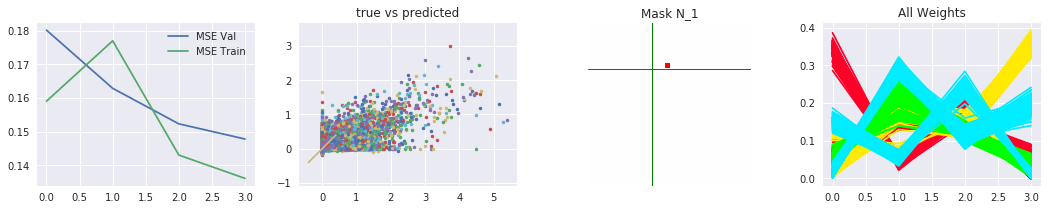

Total FEV =  0.423587459008
Runs: 500; MSE - train: 0.139572, val: 0.144917165628; lr = 0.001
best run:  500 0.144917165628
Loss/Regularization: 0.04488433199 MSE, 0.0 kernel, 0.0501260459423 mask, 5.04464328289e-05 weights


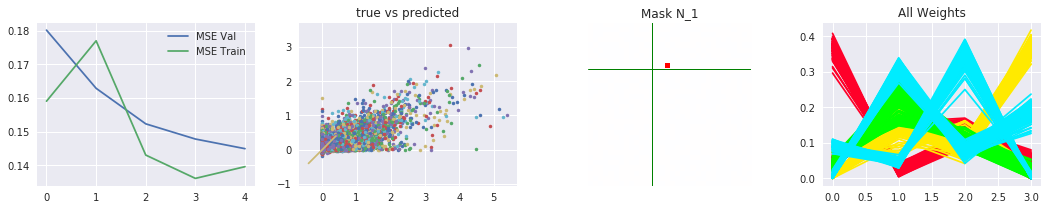

Total FEV =  0.480734153065
Runs: 600; MSE - train: 0.126546, val: 0.140323030879; lr = 0.001
best run:  600 0.140323030879
Loss/Regularization: 0.0404344093986 MSE, 0.0 kernel, 0.0485450923443 mask, 4.60831433535e-05 weights


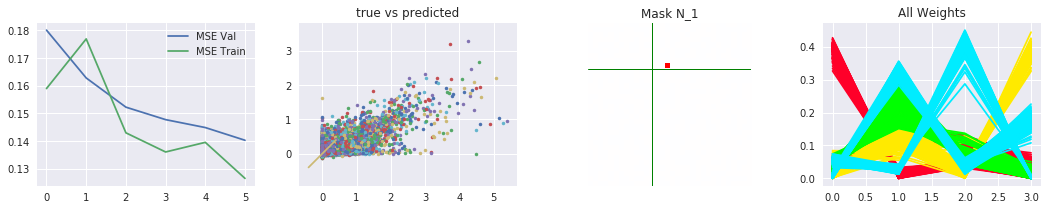

Total FEV =  0.4976578913
Runs: 700; MSE - train: 0.129096, val: 0.138901580242; lr = 0.001
best run:  700 0.138901580242
Loss/Regularization: 0.0391165846959 MSE, 0.0 kernel, 0.0469031631947 mask, 4.50434535742e-05 weights


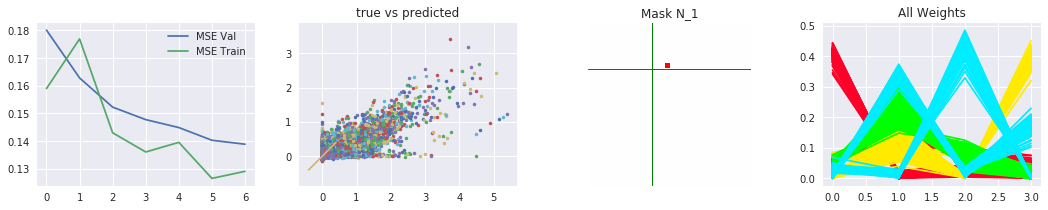

Total FEV =  0.540270465574
Runs: 800; MSE - train: 0.140189, val: 0.135569320526; lr = 0.001
best run:  800 0.135569320526
Loss/Regularization: 0.0357984110015 MSE, 0.0 kernel, 0.04680595994 mask, 4.5687815547e-05 weights


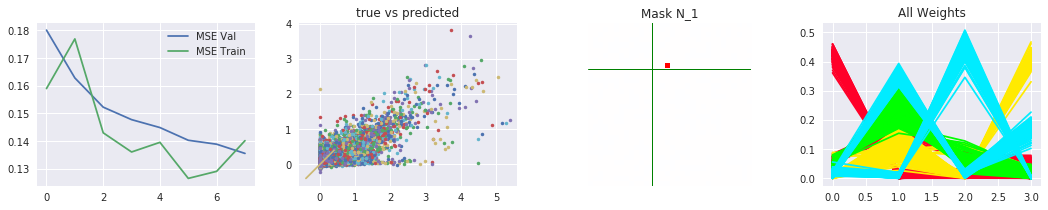

Total FEV =  0.551574096903
Runs: 900; MSE - train: 0.121253, val: 0.134642416728; lr = 0.001
best run:  900 0.134642416728
Loss/Regularization: 0.0349182151258 MSE, 0.0 kernel, 0.0450828939676 mask, 4.68471646309e-05 weights


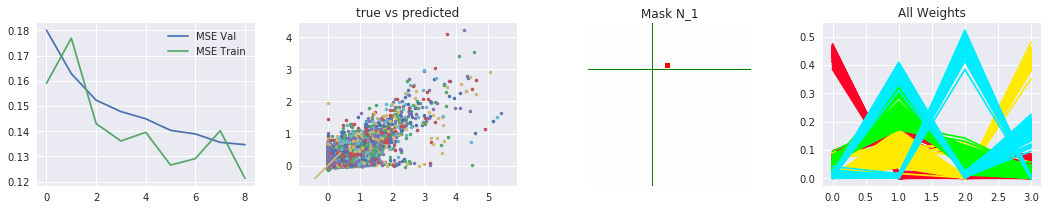

Total FEV =  0.580125139635
Runs: 1000; MSE - train: 0.114171, val: 0.132351419772; lr = 0.001
best run:  1000 0.132351419772
Loss/Regularization: 0.0326949906303 MSE, 0.0 kernel, 0.0444582402706 mask, 4.82941448689e-05 weights


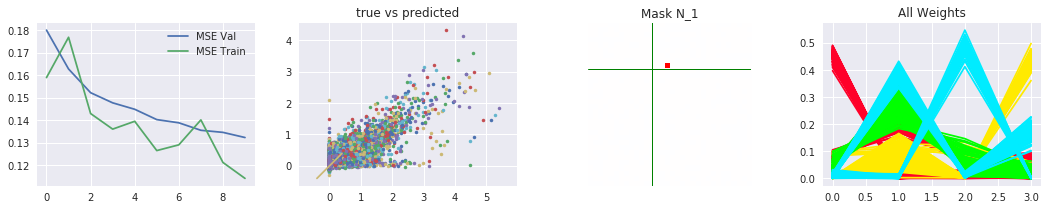

Total FEV =  0.606775625849
Runs: 1100; MSE - train: 0.125314, val: 0.130364680663; lr = 0.001
best run:  1100 0.130364680663
Loss/Regularization: 0.0306197594618 MSE, 0.0 kernel, 0.0438836157322 mask, 4.98860538006e-05 weights


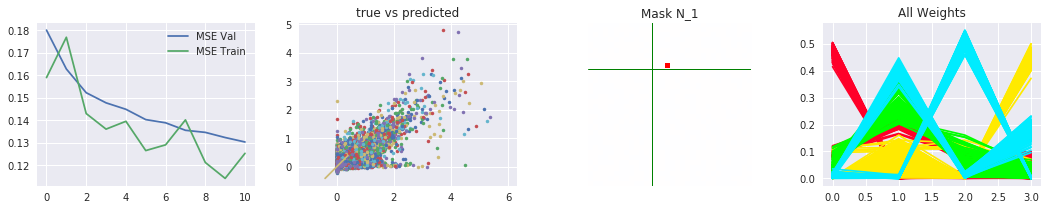

Total FEV =  0.612554286263
Runs: 1200; MSE - train: 0.116134, val: 0.129911408876; lr = 0.001
best run:  1200 0.129911408876
Loss/Regularization: 0.0301697843242 MSE, 0.0 kernel, 0.043215957284 mask, 5.14255642891e-05 weights


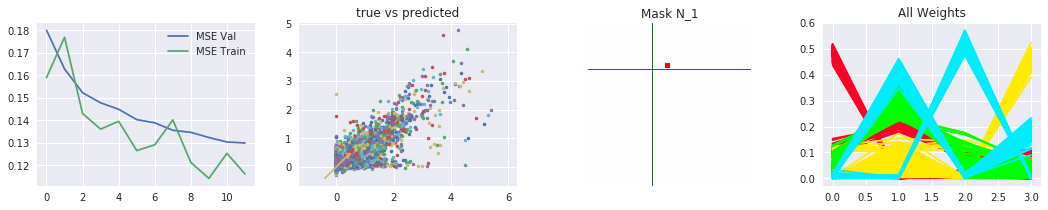

Total FEV =  0.626648868348
Runs: 1300; MSE - train: 0.14502, val: 0.12896099803; lr = 0.001
best run:  1300 0.12896099803
Loss/Regularization: 0.0290722615318 MSE, 0.0 kernel, 0.0431940793991 mask, 5.30706644058e-05 weights


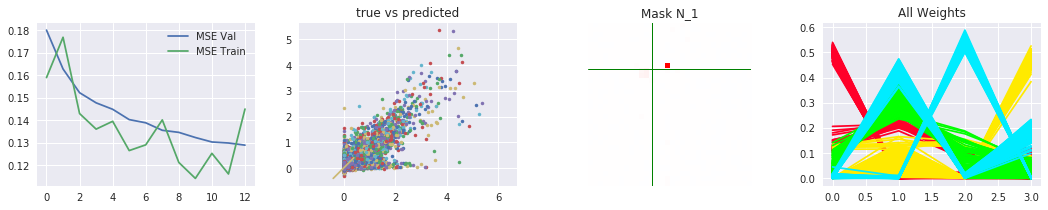

Total FEV =  0.631323538637
Runs: 1400; MSE - train: 0.119164, val: 0.128458842402; lr = 0.001
best run:  1400 0.128458842402
Loss/Regularization: 0.0287082523573 MSE, 0.0 kernel, 0.0427905738354 mask, 5.47180593014e-05 weights


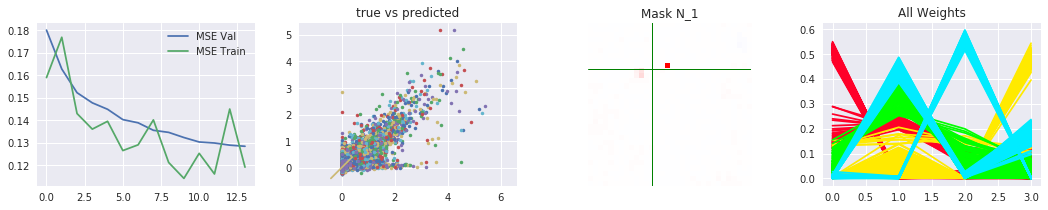

Total FEV =  0.640499792561
Runs: 1500; MSE - train: 0.100926, val: 0.127791257575; lr = 0.001
best run:  1500 0.127791257575
Loss/Regularization: 0.0279937119922 MSE, 0.0 kernel, 0.0434900671244 mask, 5.63452720642e-05 weights


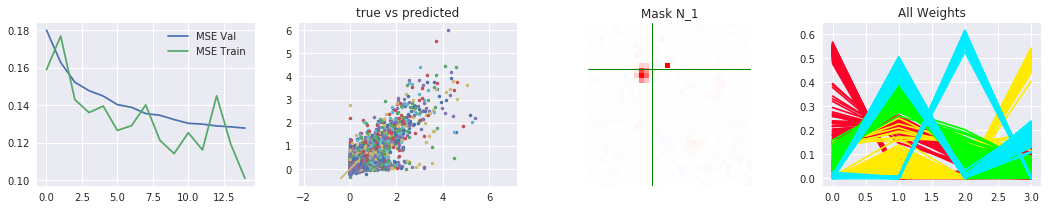

Total FEV =  0.641062414268
Runs: 1600; MSE - train: 0.117028, val: 0.127816216089; lr = 0.001
best run:  1500 0.127791257575
Loss/Regularization: 0.0279499015305 MSE, 0.0 kernel, 0.0442792832851 mask, 5.78465163708e-05 weights


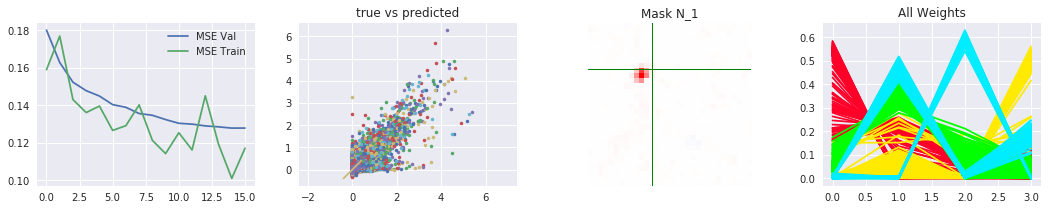

Total FEV =  0.653423468645
Runs: 1700; MSE - train: 0.131506, val: 0.126828532666; lr = 0.001
best run:  1700 0.126828532666
Loss/Regularization: 0.0269873657962 MSE, 0.0 kernel, 0.0440040290356 mask, 5.89730143547e-05 weights


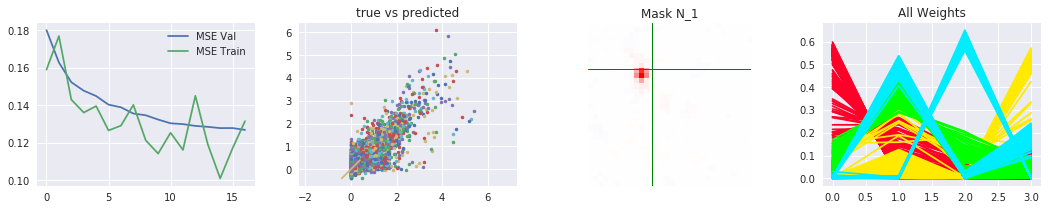

Total FEV =  0.646065627027
Runs: 1800; MSE - train: 0.125049, val: 0.127388563356; lr = 0.001
best run:  1700 0.126828532666
Loss/Regularization: 0.0275603092741 MSE, 0.0 kernel, 0.0437610238791 mask, 5.98252773285e-05 weights


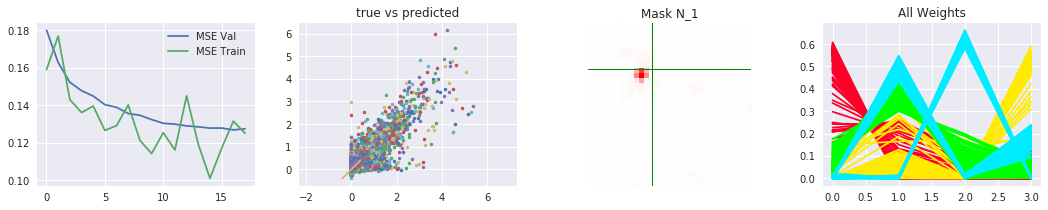

Total FEV =  0.643811368244
Runs: 1900; MSE - train: 0.121682, val: 0.127628362505; lr = 0.001
best run:  1700 0.126828532666
Loss/Regularization: 0.0277358448366 MSE, 0.0 kernel, 0.0435647785664 mask, 6.0760819912e-05 weights


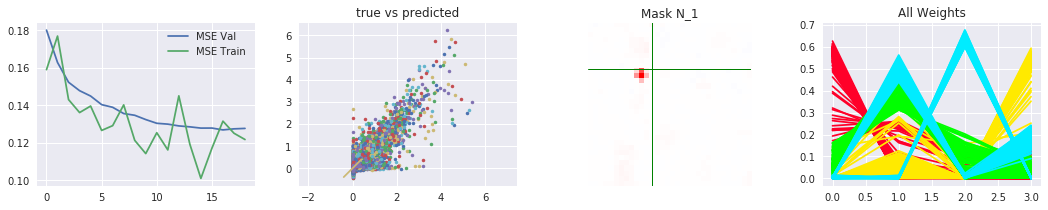

Total FEV =  0.669373155463
Runs: 2000; MSE - train: 0.128142, val: 0.125373929041; lr = 0.001
best run:  2000 0.125373929041
Loss/Regularization: 0.0257453889353 MSE, 0.0 kernel, 0.0431750684977 mask, 6.15737736225e-05 weights


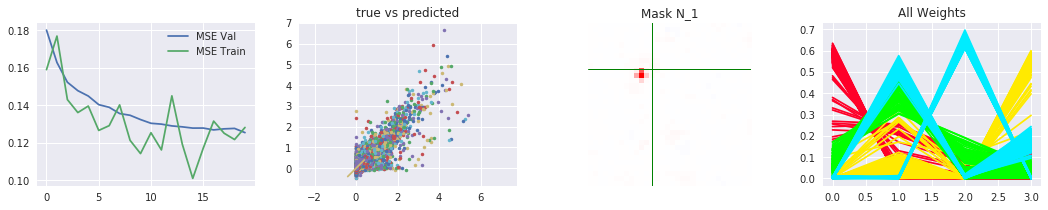

Total FEV =  0.66605077074
Runs: 2100; MSE - train: 0.118632, val: 0.125617317623; lr = 0.001
best run:  2000 0.125373929041
Loss/Regularization: 0.0260040977737 MSE, 0.0 kernel, 0.0434020102024 mask, 6.24098598957e-05 weights


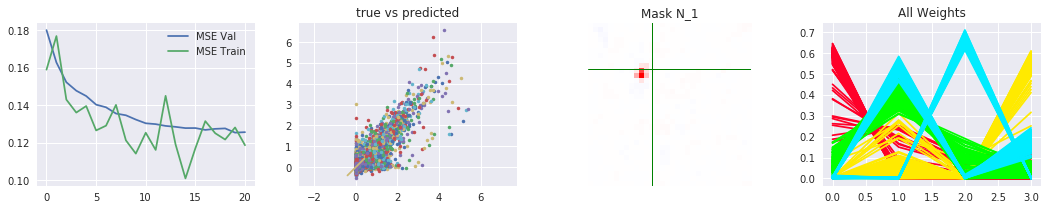

Total FEV =  0.633261911843
Runs: 2200; MSE - train: 0.118628, val: 0.128419873887; lr = 0.001
best run:  2000 0.125373929041
Loss/Regularization: 0.0285573143046 MSE, 0.0 kernel, 0.0441604912281 mask, 6.32845103741e-05 weights


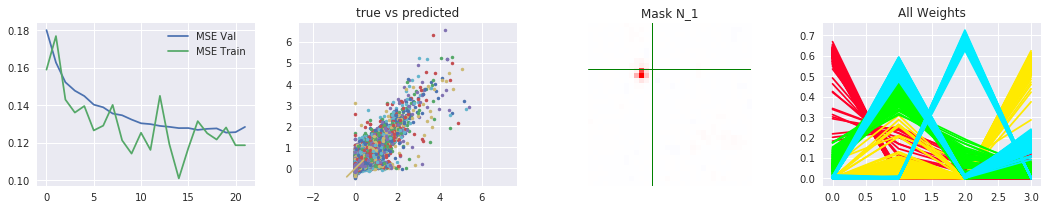

Total FEV =  0.663107258542
Runs: 2300; MSE - train: 0.103991, val: 0.125719022471; lr = 0.001
best run:  2000 0.125373929041
Loss/Regularization: 0.0262333044084 MSE, 0.0 kernel, 0.0441806256771 mask, 6.39791250229e-05 weights


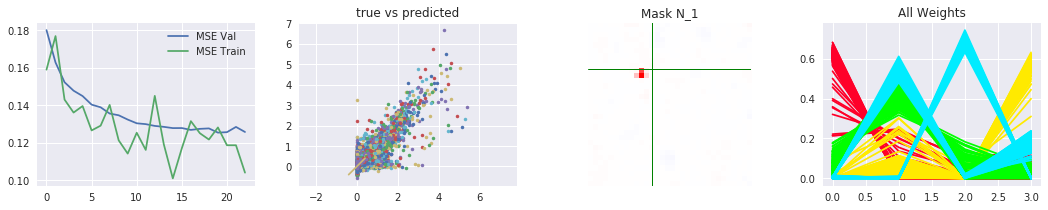

Total FEV =  0.715573980945
Runs: 2400; MSE - train: 0.129249, val: 0.121675327537; lr = 0.0001
best run:  2400 0.121675327537
Loss/Regularization: 0.0221478038002 MSE, 0.0 kernel, 0.0211695894599 mask, 6.4274585247e-05 weights


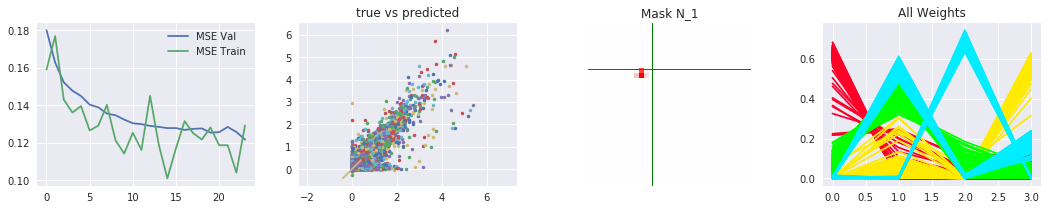

Total FEV =  0.723824622299
Runs: 2500; MSE - train: 0.12159, val: 0.120956682251; lr = 0.0001
best run:  2500 0.120956682251
Loss/Regularization: 0.0215053394204 MSE, 0.0 kernel, 0.0211553663015 mask, 6.46850705147e-05 weights


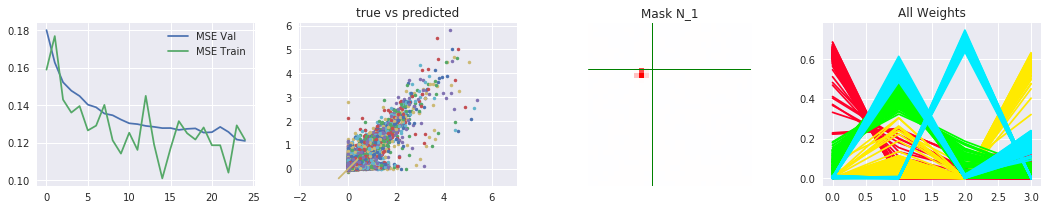

Total FEV =  0.730426816389
Runs: 2600; MSE - train: 0.114444, val: 0.120435830206; lr = 0.0001
best run:  2600 0.120435830206
Loss/Regularization: 0.0209912370192 MSE, 0.0 kernel, 0.021295389533 mask, 6.510014534e-05 weights


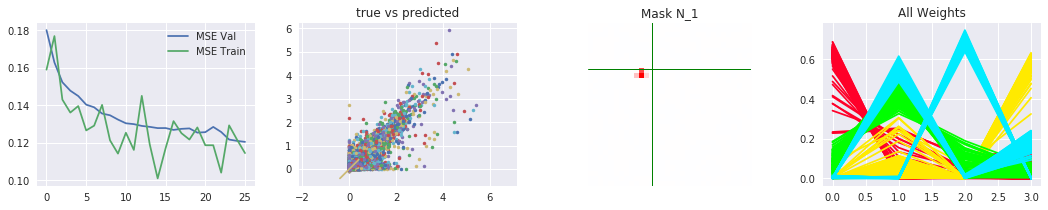

Total FEV =  0.730792846639
Runs: 2700; MSE - train: 0.114037, val: 0.120380647015; lr = 0.0001
best run:  2700 0.120380647015
Loss/Regularization: 0.0209627348231 MSE, 0.0 kernel, 0.0209061637521 mask, 6.54901266098e-05 weights


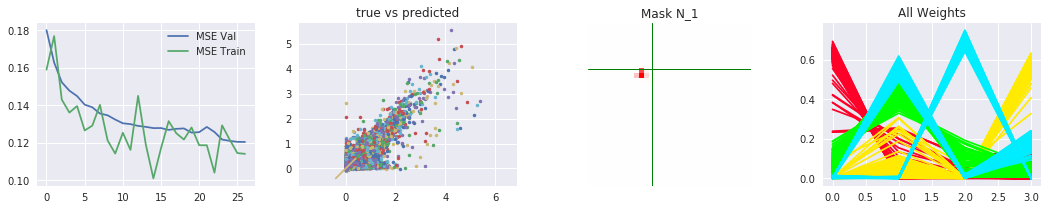

Total FEV =  0.734521998086
Runs: 2800; MSE - train: 0.11016, val: 0.120104171103; lr = 0.0001
best run:  2800 0.120104171103
Loss/Regularization: 0.020672351704 MSE, 0.0 kernel, 0.0213773876429 mask, 6.59096062183e-05 weights


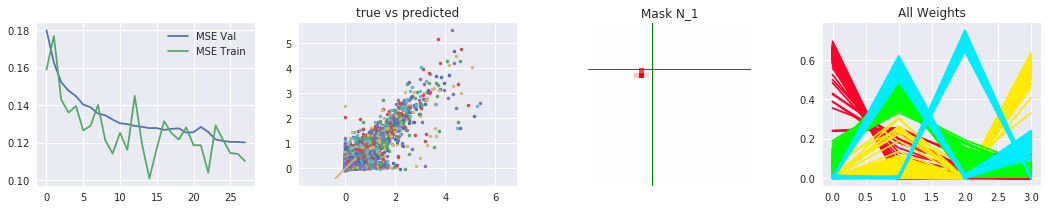

Total FEV =  0.73380500446
Runs: 2900; MSE - train: 0.117636, val: 0.120112143573; lr = 0.0001
best run:  2800 0.120104171103
Loss/Regularization: 0.0207281828625 MSE, 0.0 kernel, 0.0211253657937 mask, 6.63234055042e-05 weights


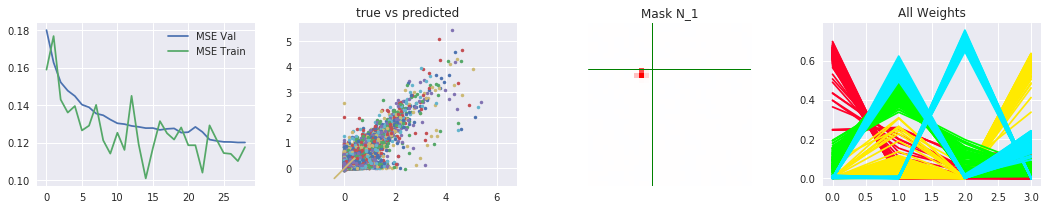

('Stop at run 2999; MSE on validation set: 0.120104171103', 'MSE on test set: 0.020672350541; Mean FEV: 0.66096463352')
.r mean values of weights:  [ 0.62  0.01  0.01  0.01]
.b mean values of weights:  [ 0.          0.06        0.          0.56999999]
.g mean values of weights:  [ 0.08        0.49000001  0.03        0.04      ]
.y mean values of weights:  [ 0.          0.31        0.31999999  0.1       ]


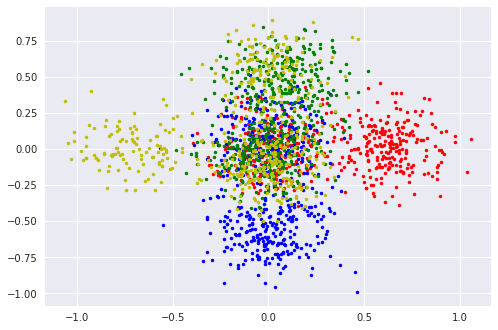

run took 618.4078240394592 s to optimize


Text(0,0.5,'FEV')

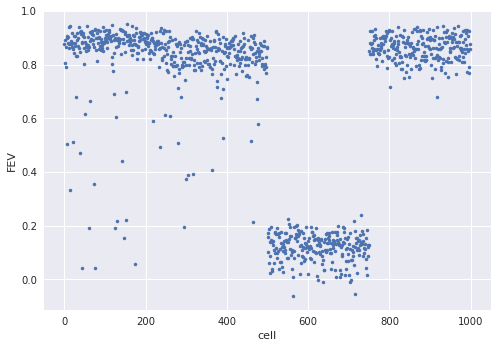

In [98]:
#Suggestion: use this to get an intuition for the range of regularization values
#for different numbers of neurons to be gridsearched over below

start = time.time()
#Seeds
np_seed=1295
np.random.seed(np_seed)
tf_seed=4729


#Data, keep test set for later
num_test = 2**10
ind = np.random.choice(X.shape[0],X.shape[0],replace=False)
X_TEST = X[ind[:num_test],...]
GT_TEST = (Y[:,ind[:num_test]].T / np.mean(Y,1)).T * .1#mean response=.1
X_try = X[ind[num_test:],...]
Y_try = Y[:,ind[num_test:]]

#Data
split_data=True#set true for large nets to fit on GPU memory
batch_size = 64
D=2**15#number of training+val images
num_val = D//8
num_train = D-num_val
Y_train,Y_val,X_train,X_val,X_test,GT_test = splitting_data(X=X_try,Y=Y_try,
   num_train=num_train,num_test=num_test,num_val=num_val,noise=True,mean_response=.1)

print('Images for Training: %s, Validation: %s, Testing %s'%(
      Y_train.shape[1],Y_val.shape[1],GT_test.shape[1]))

#Neurons
N=1000
ind = np.random.choice(250,N//4,replace=False)
ind = np.concatenate([ind,ind+250,ind+500,ind+750])
#ind[0]=0
Y_train=Y_train[ind,:]
Y_val=Y_val[ind,:]
GT_test=GT_test[ind,:]

#Ground truth locations
GT_mask = np.hstack([loc_y.reshape([-1,1]),loc_x.reshape([-1,1])])[ind,:]

#Parameters:
s=[44,3,32]#sizes of [image(heigth=width), image(depth=channel), mask]
sk=[5,5,5]#width=heigth of receptive field and conv kernel
num_kern = [32,64,4]#number of bases (conv kernels) to learn per layer
#N=Y_train.shape[0]#neurons
init_scales = np.array([[0,.01],[1,.001],[1/num_kern[-1],.01]])#Mean/SD for Kernel,Mask,Weights
lr= .001 # initial learning rate
reg = [0,.05,.0001]#np.array([0,.6,.12]) * N/1000
#[0,.0000464,.00000278]#regularization parameters: L2 Kernels, L1 Mask, L1 Weights
max_runs = 3000 # training steps
act_fn=['relu','relu','relu']#activation function per layer in model
kernel_constraint=None
weights_constraint='abs'#'norm'#None#constrain read out weights to norm=1
stop_crit = [3,2]#[after how many worse steps lower lr, lower how many times]
burn_in=10#allow for burn_in*100 initial runs without triggering stop criterion
bn_cent=True#center after batch norm

#calculate spike triggered average to initialize location masks
X_sta=np.mean(X_train,axis=1).reshape([-1,s[0]**2]).T
sta,_=pre_process.STA(X_sta,Y_train,s[-1],np.int(s[-1]/2))

print('it took %s s to preprocess data'%(time.time()-start))

#for rep in range(5):
#Train Model

#for i in range(2,10):
start = time.time()
(WK,WM,WW,MSE_train,MSE_val,MSE_test,FEV,FEV_cell,Y_,
log) = training.train(s=s,#        sizes of [image(heigth=width), image(depth=channel), mask]
          sK=sk,#        s - sizes of [kernel1, kernel2, ...] - length of list gives number of layers
          act_fn=act_fn,#      activation functions for each kernel = 'ID' or 'relu'
          init_scales=init_scales,# rows: kernel,mask,weights; columns: mean, sd
          init_lr=lr,# initial learning rate, goes down later
          num_kern=num_kern,#        num_kern - number of kernels per conv layer
          max_runs=max_runs,# maximum number of training steps
          reg=reg,#        regularization weights [Kernel,Mask,Weights]
          batch_size=batch_size,# (max gpu memory?)256 for small one layer, 64 for large multilayer model
          X_train=X_train,
          X_val=X_val,
          X_test=X_test,
          Y_train=Y_train,
          Y_val=Y_val,
          GT_test=GT_test,#Data, X in NCHW format, Y: Neurons x Data
          kernel_constraint=kernel_constraint,#constraint for kernel weights - 'norm' == 1
          weights_constraint=weights_constraint,#constraint on read out weights - 'abs','norm','absnorm'
          mask_constraint=None,#constraint on mask - 'abs'
          final_relu=False,
          stop_crit=stop_crit,#[after how many worse steps lower lr, lower how many times]
          burn_in=burn_in,#allow initial exploration of 100*burn_in runs 
          types=[0,N//4,N//4*2,N//4*3],#starting indices of types, default=all same type
          GT_mask=GT_mask,#true locations if known: rows:neurons, columns: x,y location
          tf_seed=tf_seed,#random seed for tensorflow
          np_seed=np_seed,
          split_data=split_data,#whether to go through test and val set in batch_size chunks
          sta=sta,#if provided, take maximum absolute pixel of sta to initialize mask
          bn_cent=bn_cent,#center after batch norm?
          verbose='yes')#stats every 100 steps (takes much longer), 'yes','no','minimal'

#plotting
c = ['.r','.b','.g','.y']
for i in range(4):
    print(c[i],'mean values of weights: ',np.around(np.mean(WW[:,i*(N//4):(i+1)*(N//4)],1),2))
    plt.plot(WW[0,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),
                WW[1,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),c[i])
    plt.plot(-WW[2,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),
                -WW[3,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),c[i])
plt.show()

print('run took %s s to optimize'%(time.time()-start))
#Plot Model performance on individual cells
plt.plot(FEV_cell,'.')
plt.xlabel('cell')
plt.ylabel('FEV')

Images for Training: 448, Validation: 64, Testing 1024
it took 2.312096357345581 s to preprocess data
Before Training:
Total FEV =  -0.0597278681372
Loss/Regularization: 0.0871509963181 MSE, 0.0 kernel, 0.181102848053 mask, 0.000998689353466 weights


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


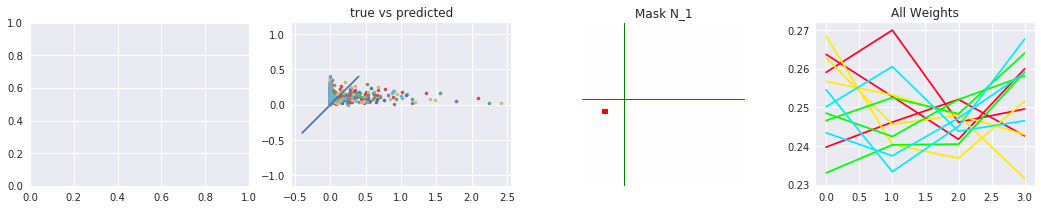

Total FEV =  -0.121666249262
Runs: 100; MSE - train: 0.283226, val: 0.245976299047; lr = 0.001
best run:  100 0.245976299047
Loss/Regularization: 0.0922447489575 MSE, 0.0 kernel, 0.106236600876 mask, 0.000765432596207 weights


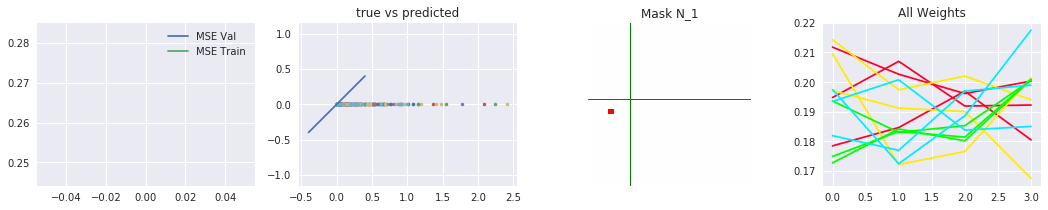

Total FEV =  -0.119026817925
Runs: 200; MSE - train: 0.18716, val: 0.244584321976; lr = 0.001
best run:  200 0.244584321976
Loss/Regularization: 0.0920276846737 MSE, 0.0 kernel, 0.0986987769604 mask, 0.00064962553978 weights


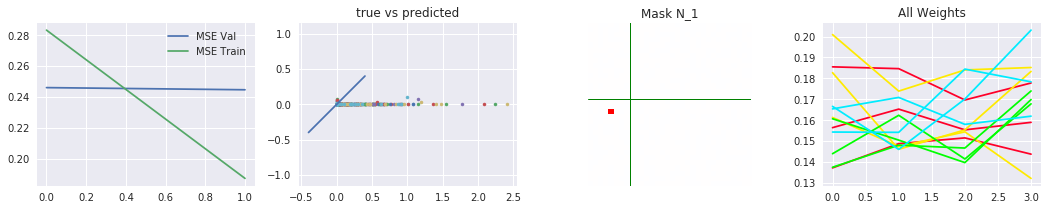

Total FEV =  -0.0629295564097
Runs: 300; MSE - train: 0.154986, val: 0.236507296562; lr = 0.001
best run:  300 0.236507296562
Loss/Regularization: 0.0874143000692 MSE, 0.0 kernel, 0.0920110166073 mask, 0.000583567023277 weights


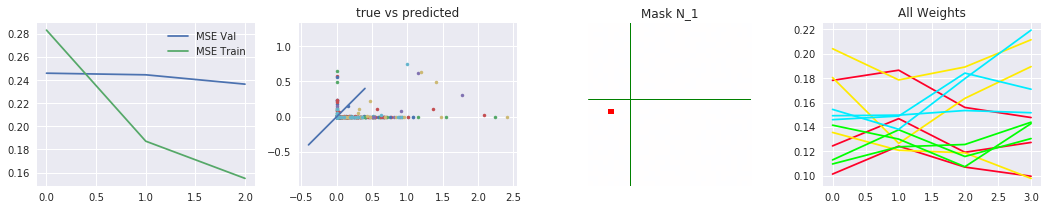

Total FEV =  0.0298265589199
Runs: 400; MSE - train: 0.201608, val: 0.227332741022; lr = 0.001
best run:  400 0.227332741022
Loss/Regularization: 0.0797861267347 MSE, 0.0 kernel, 0.0853114724159 mask, 0.000542507410049 weights


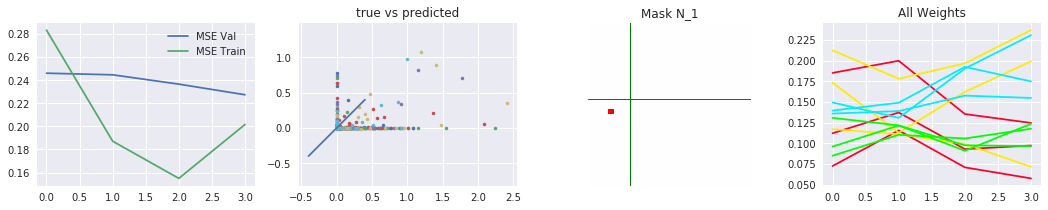

Total FEV =  0.0511797437041
Runs: 500; MSE - train: 0.132556, val: 0.225995212793; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0780300614424 MSE, 0.0 kernel, 0.0784368216991 mask, 0.000517642974854 weights


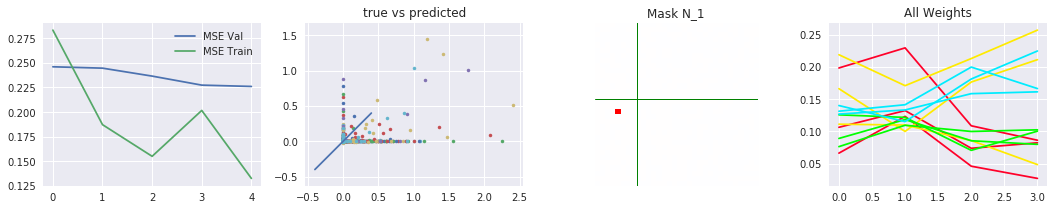

Total FEV =  0.066018596533
Runs: 600; MSE - train: 0.137484, val: 0.23220539093; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0768097285181 MSE, 0.0 kernel, 0.0708896994591 mask, 0.000510248839855 weights


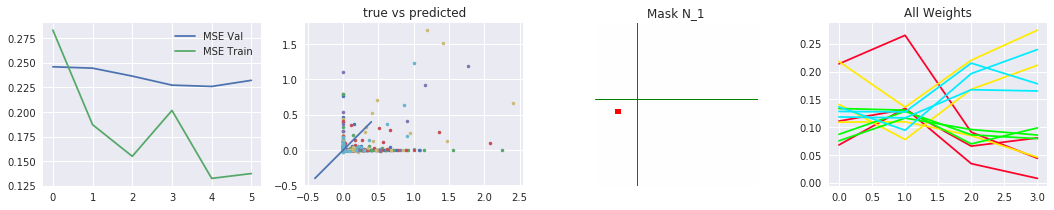

Total FEV =  0.0754587782876
Runs: 700; MSE - train: 0.133952, val: 0.244190618396; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0760333770886 MSE, 0.0 kernel, 0.0649598181248 mask, 0.000512490391731 weights


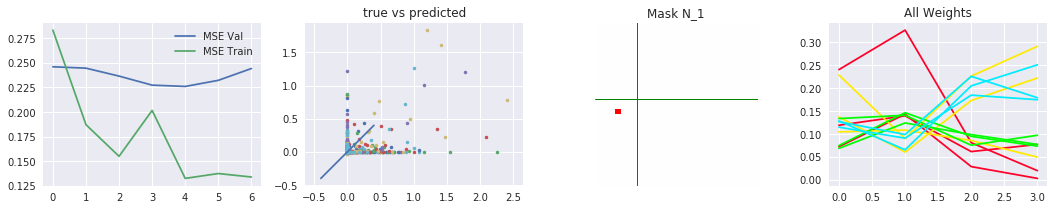

Total FEV =  0.0854964335927
Runs: 800; MSE - train: 0.112419, val: 0.235051184893; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0752078900114 MSE, 0.0 kernel, 0.0593010544777 mask, 0.000526467621326 weights


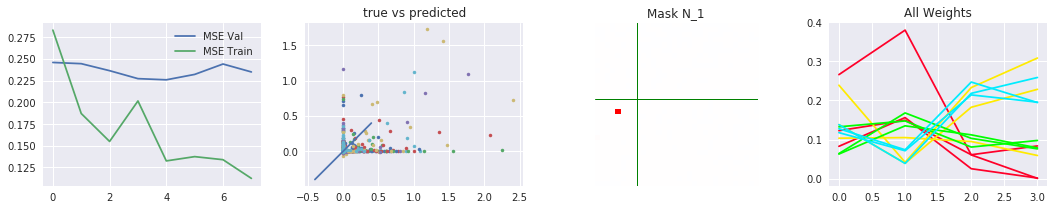

Total FEV =  0.0909151236945
Runs: 900; MSE - train: 0.12492, val: 0.228701472282; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0747622621711 MSE, 0.0 kernel, 0.052420759201 mask, 0.000549716830254 weights


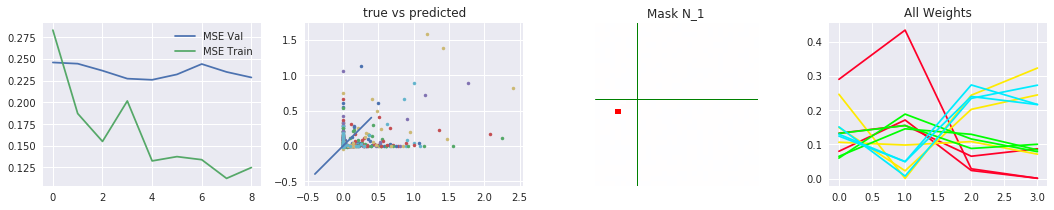

Total FEV =  0.0862345074742
Runs: 1000; MSE - train: 0.146802, val: 0.232983529568; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0751471915282 MSE, 0.0 kernel, 0.0485923618078 mask, 0.000586805343628 weights


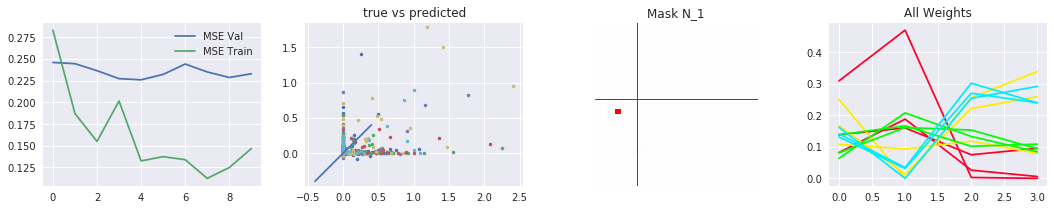

Total FEV =  0.0845051109451
Runs: 1100; MSE - train: 0.215537, val: 0.228188186884; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0752894154284 MSE, 0.0 kernel, 0.0431884884834 mask, 0.000638450860977 weights


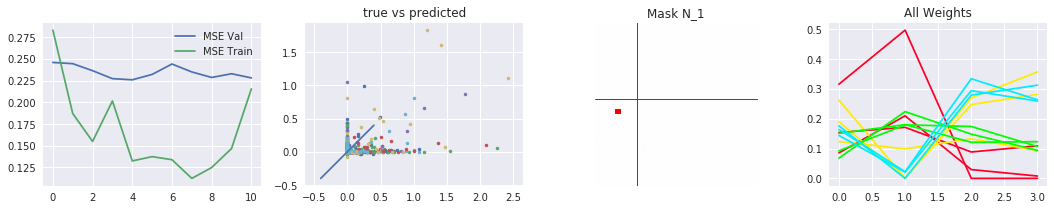

Total FEV =  0.0551565117566
Runs: 1200; MSE - train: 0.198268, val: 0.230171442032; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0777030158788 MSE, 0.0 kernel, 0.041440731287 mask, 0.000692373216152 weights


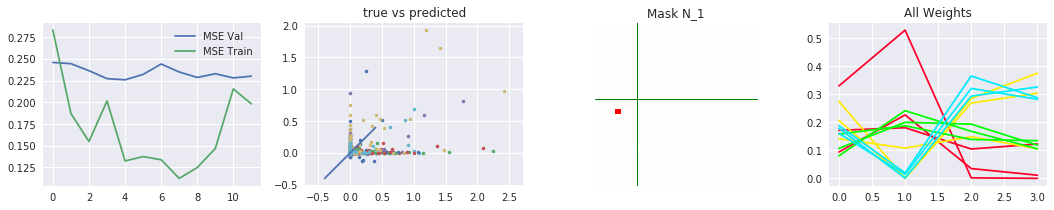

Total FEV =  0.0650096245266
Runs: 1300; MSE - train: 0.252971, val: 0.229315161705; lr = 0.001
best run:  500 0.225995212793
Loss/Regularization: 0.0768927054014 MSE, 0.0 kernel, 0.0380656242371 mask, 0.000743427813053 weights


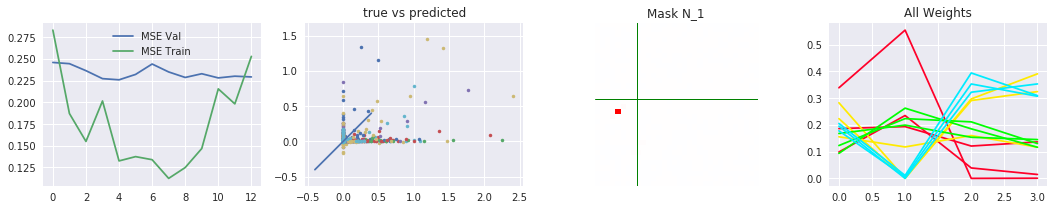

Total FEV =  0.0455723266345
Runs: 1400; MSE - train: 0.211279, val: 0.226077824831; lr = 0.0001
best run:  500 0.225995212793
Loss/Regularization: 0.0784912100062 MSE, 0.0 kernel, 0.0154293775558 mask, 0.000747885882854 weights


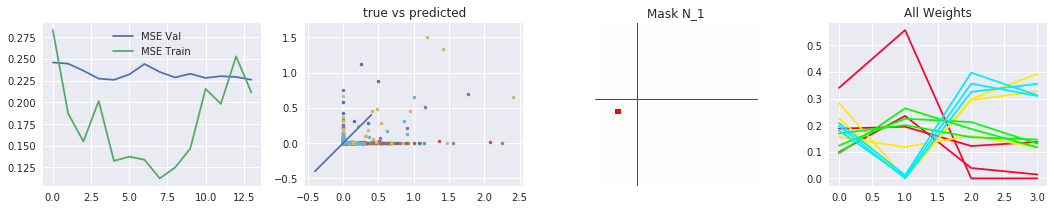

Total FEV =  0.0462778819828
Runs: 1500; MSE - train: 0.189713, val: 0.224204480648; lr = 0.0001
best run:  1500 0.224204480648
Loss/Regularization: 0.0784331858158 MSE, 0.0 kernel, 0.0152483463287 mask, 0.000752243638039 weights


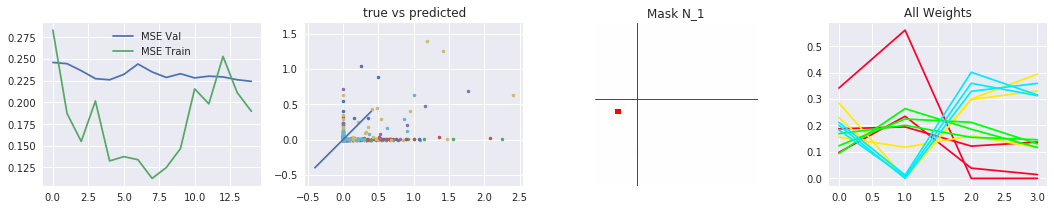

Total FEV =  0.0462145945638
Runs: 1600; MSE - train: 0.139537, val: 0.222046107054; lr = 0.0001
best run:  1600 0.222046107054
Loss/Regularization: 0.078438390512 MSE, 0.0 kernel, 0.0152272805572 mask, 0.000756467401981 weights


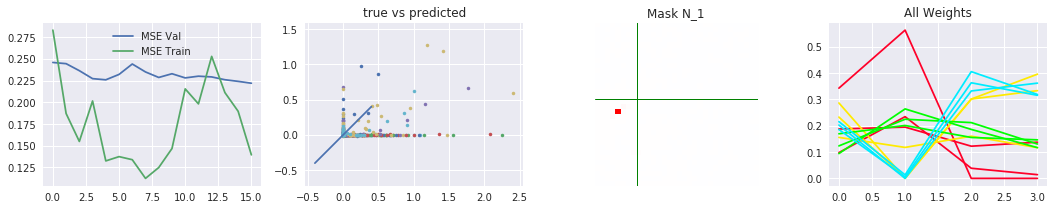

Total FEV =  0.0469182672005
Runs: 1700; MSE - train: 0.203523, val: 0.220876514912; lr = 0.0001
best run:  1700 0.220876514912
Loss/Regularization: 0.078380521154 MSE, 0.0 kernel, 0.0153303876519 mask, 0.000760465204716 weights


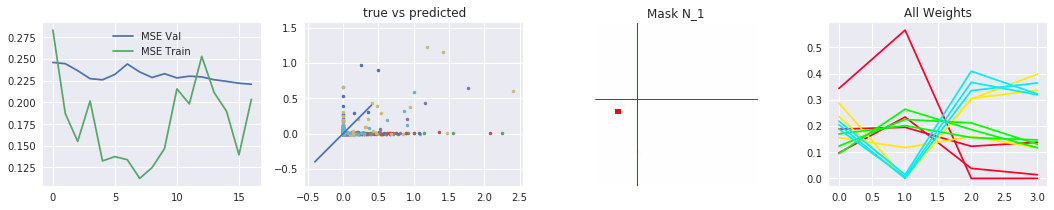

Total FEV =  0.0431417573699
Runs: 1800; MSE - train: 0.171742, val: 0.220407620072; lr = 0.0001
best run:  1800 0.220407620072
Loss/Regularization: 0.0786910976749 MSE, 0.0 kernel, 0.0150310277939 mask, 0.000764589309692 weights


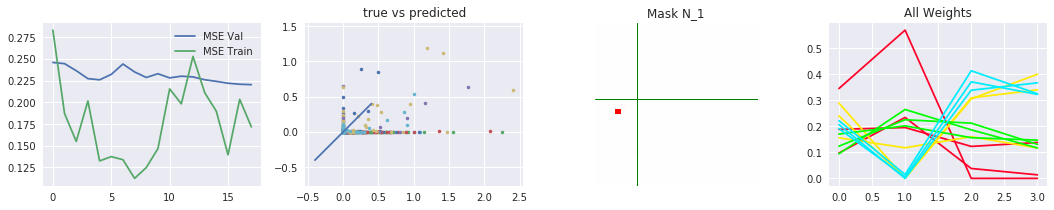

Total FEV =  0.0429098469451
Runs: 1900; MSE - train: 0.166078, val: 0.219977945089; lr = 0.0001
best run:  1900 0.219977945089
Loss/Regularization: 0.0787101697642 MSE, 0.0 kernel, 0.0152081295848 mask, 0.000768804311752 weights


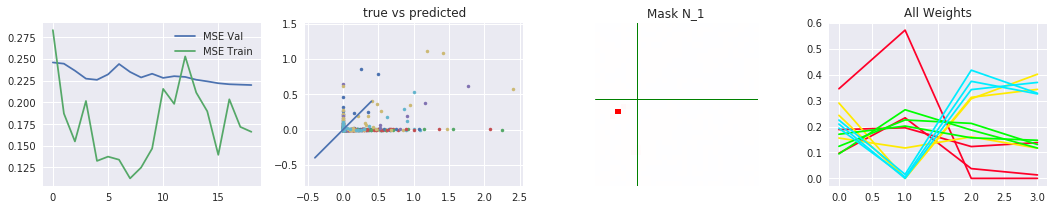

Total FEV =  0.0436827524056
Runs: 2000; MSE - train: 0.144269, val: 0.220310360193; lr = 0.0001
best run:  1900 0.219977945089
Loss/Regularization: 0.0786466067657 MSE, 0.0 kernel, 0.0151286885142 mask, 0.000772742509842 weights


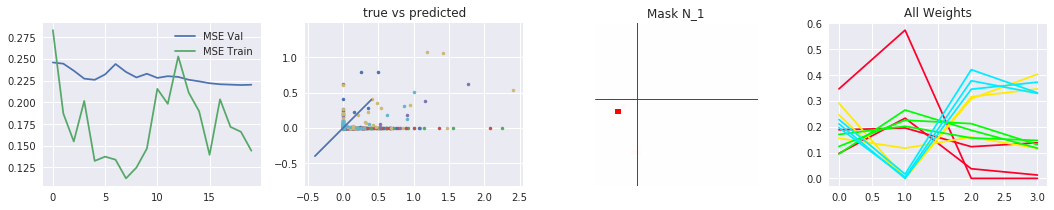

Total FEV =  0.0452043655289
Runs: 2100; MSE - train: 0.161168, val: 0.219823881984; lr = 0.0001
best run:  2100 0.219823881984
Loss/Regularization: 0.0785214707721 MSE, 0.0 kernel, 0.0149793609977 mask, 0.000776903510094 weights


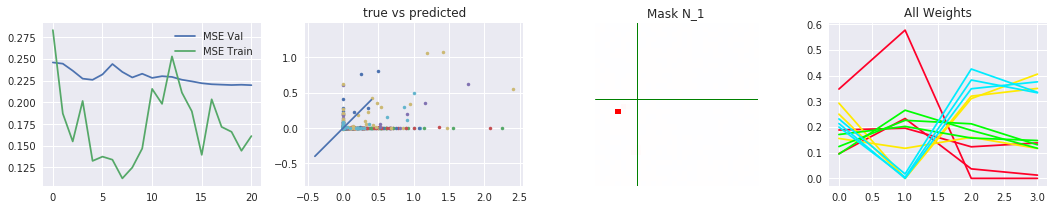

Total FEV =  0.0417002458367
Runs: 2200; MSE - train: 0.135516, val: 0.218619346619; lr = 0.0001
best run:  2200 0.218619346619
Loss/Regularization: 0.0788096461911 MSE, 0.0 kernel, 0.0152930185199 mask, 0.000781135678291 weights


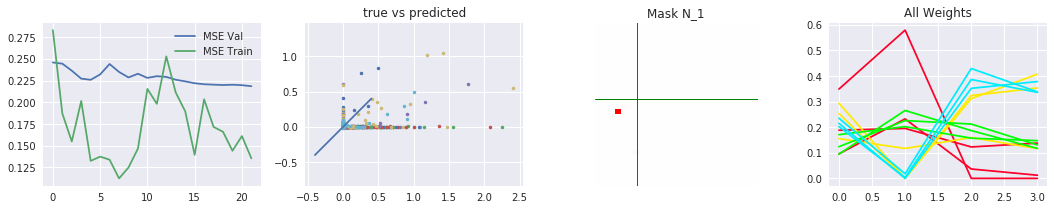

Total FEV =  0.0405216740792
Runs: 2300; MSE - train: 0.209586, val: 0.219041526318; lr = 0.0001
best run:  2200 0.218619346619
Loss/Regularization: 0.0789065707941 MSE, 0.0 kernel, 0.015211430192 mask, 0.00078501200676 weights


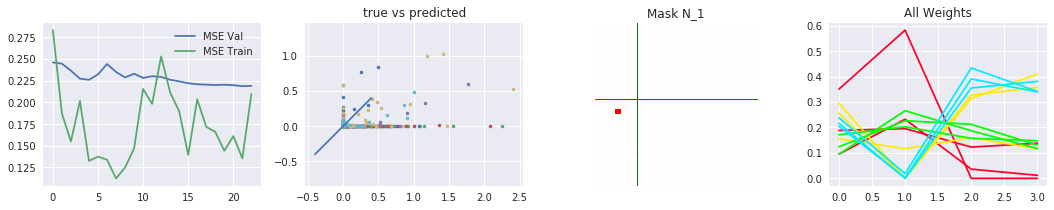

Total FEV =  0.044866725988
Runs: 2400; MSE - train: 0.154077, val: 0.219310939312; lr = 0.0001
best run:  2200 0.218619346619
Loss/Regularization: 0.0785492379218 MSE, 0.0 kernel, 0.0151206016541 mask, 0.000789702892303 weights


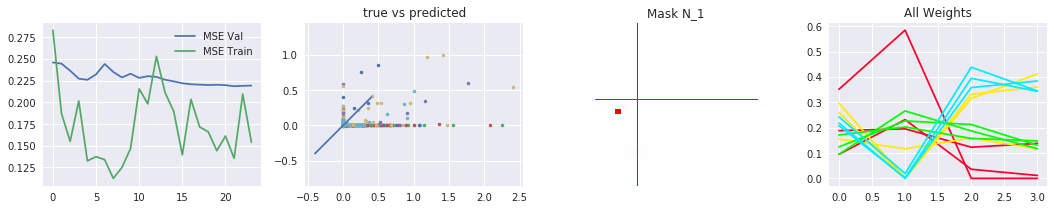

Total FEV =  0.0402758230956
Runs: 2500; MSE - train: 0.136821, val: 0.219222426414; lr = 0.0001
best run:  2200 0.218619346619
Loss/Regularization: 0.0789267893415 MSE, 0.0 kernel, 0.0150548398495 mask, 0.000793694257736 weights


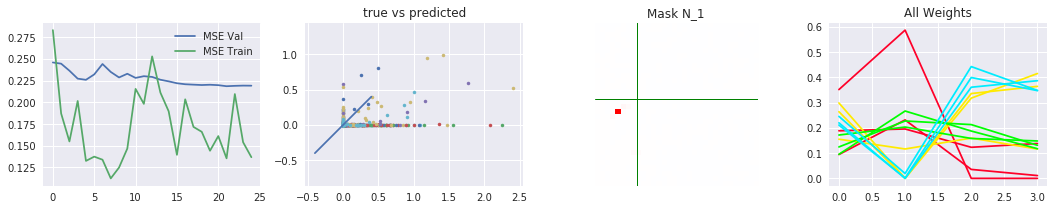

('Stop at run 2500; MSE on validation set: 0.218619346619', 'MSE on test set: 0.0788096479746; Mean FEV: 0.0102346444303')
.r mean values of weights:  [ 0.20999999  0.34        0.05        0.05      ]
.b mean values of weights:  [ 0.23        0.04        0.27000001  0.28999999]
.g mean values of weights:  [ 0.13  0.23  0.19  0.13]
.y mean values of weights:  [ 0.22        0.01        0.38999999  0.34999999]


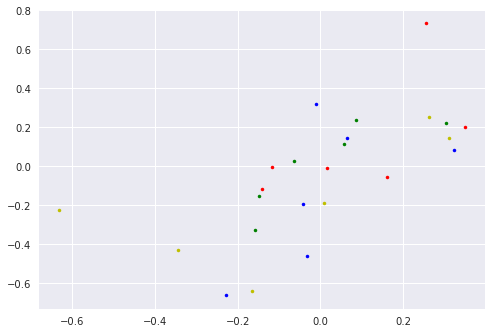

run took 375.9644498825073 s to optimize


Text(0,0.5,'FEV')

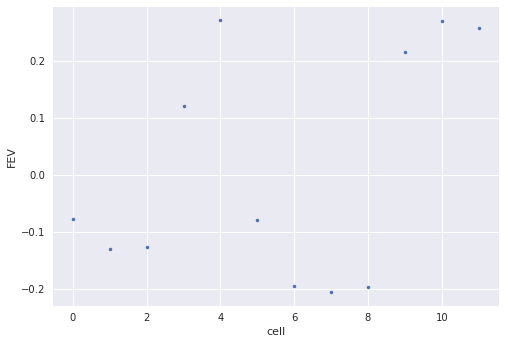

In [90]:
## DROPOUT?

#Suggestion: use this to get an intuition for the range of regularization values
#for different numbers of neurons to be gridsearched over below

start = time.time()
#Seeds
np_seed=1295
np.random.seed(np_seed)
tf_seed=4729


#Data, keep test set for later
num_test = 2**10
ind = np.random.choice(X.shape[0],X.shape[0],replace=False)
X_TEST = X[ind[:num_test],...]
GT_TEST = (Y[:,ind[:num_test]].T / np.mean(Y,1)).T * .1#mean response=.1
X_try = X[ind[num_test:],...]
Y_try = Y[:,ind[num_test:]]

#Data
split_data=True#set true for large nets to fit on GPU memory
batch_size = 64
D=2**9#number of training+val images
num_val = D//8
num_train = D-num_val
Y_train,Y_val,X_train,X_val,X_test,GT_test = splitting_data(X=X_try,Y=Y_try,
   num_train=num_train,num_test=num_test,num_val=num_val,noise=True,mean_response=.1)

print('Images for Training: %s, Validation: %s, Testing %s'%(
      Y_train.shape[1],Y_val.shape[1],GT_test.shape[1]))

#Neurons
N=12
ind = np.random.choice(250,N//4,replace=False)
ind = np.concatenate([ind,ind+250,ind+500,ind+750])
#ind[0]=0
Y_train=Y_train[ind,:]
Y_val=Y_val[ind,:]
GT_test=GT_test[ind,:]

#Ground truth locations
GT_mask = np.hstack([loc_y.reshape([-1,1]),loc_x.reshape([-1,1])])[ind,:]

#Parameters:
s=[44,3,32]#sizes of [image(heigth=width), image(depth=channel), mask]
sk=[5,5,5]#width=heigth of receptive field and conv kernel
num_kern = [32,64,4]#number of bases (conv kernels) to learn per layer
#N=Y_train.shape[0]#neurons
init_scales = np.array([[0,.01],[1,.001],[1/num_kern[-1],.01]])#Mean/SD for Kernel,Mask,Weights
lr= .001 # initial learning rate
reg = [0,.1,.01,.5]#regularization parameters: L2 Kernels, L1 Mask, L1 Weights, Droputout in convlayers
max_runs = 3000 # training steps
act_fn=['relu','relu','relu']#activation function per layer in model
kernel_constraint=None
weights_constraint='abs'#'norm'#None#constrain read out weights to norm=1
stop_crit = [3,2]#[after how many worse steps lower lr, lower how many times]
burn_in=10#allow for burn_in*100 initial runs without triggering stop criterion
bn_cent=True#center after batch norm

#calculate spike triggered average to initialize location masks
X_sta=np.mean(X_train,axis=1).reshape([-1,s[0]**2]).T
sta,_=pre_process.STA(X_sta,Y_train,s[-1],np.int(s[-1]/2))

print('it took %s s to preprocess data'%(time.time()-start))

#for rep in range(5):
#Train Model

#for i in range(2,10):
start = time.time()
(WK,WM,WW,MSE_train,MSE_val,MSE_test,FEV,FEV_cell,Y_,
log) = training.train(s=s,#        sizes of [image(heigth=width), image(depth=channel), mask]
          sK=sk,#        s - sizes of [kernel1, kernel2, ...] - length of list gives number of layers
          act_fn=act_fn,#      activation functions for each kernel = 'ID' or 'relu'
          init_scales=init_scales,# rows: kernel,mask,weights; columns: mean, sd
          init_lr=lr,# initial learning rate, goes down later
          num_kern=num_kern,#        num_kern - number of kernels per conv layer
          max_runs=max_runs,# maximum number of training steps
          reg=reg,#        regularization weights [Kernel,Mask,Weights]
          batch_size=batch_size,# (max gpu memory?)256 for small one layer, 64 for large multilayer model
          X_train=X_train,
          X_val=X_val,
          X_test=X_test,
          Y_train=Y_train,
          Y_val=Y_val,
          GT_test=GT_test,#Data, X in NCHW format, Y: Neurons x Data
          kernel_constraint=kernel_constraint,#constraint for kernel weights - 'norm' == 1
          weights_constraint=weights_constraint,#constraint on read out weights - 'abs','norm','absnorm'
          mask_constraint=None,#constraint on mask - 'abs'
          final_relu=False,
          stop_crit=stop_crit,#[after how many worse steps lower lr, lower how many times]
          burn_in=burn_in,#allow initial exploration of 100*burn_in runs 
          types=[0,N//4,N//4*2,N//4*3],#starting indices of types, default=all same type
          GT_mask=GT_mask,#true locations if known: rows:neurons, columns: x,y location
          tf_seed=tf_seed,#random seed for tensorflow
          np_seed=np_seed,
          split_data=split_data,#whether to go through test and val set in batch_size chunks
          sta=sta,#if provided, take maximum absolute pixel of sta to initialize mask
          bn_cent=bn_cent,#center after batch norm?
          verbose='yes')#stats every 100 steps (takes much longer), 'yes','no','minimal'

#plotting
c = ['.r','.b','.g','.y']
for i in range(4):
    print(c[i],'mean values of weights: ',np.around(np.mean(WW[:,i*(N//4):(i+1)*(N//4)],1),2))
    plt.plot(WW[0,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),
                WW[1,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),c[i])
    plt.plot(-WW[2,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),
                -WW[3,i*(N//4):(i+1)*(N//4)]+np.random.normal(0,.15,(N//4)),c[i])
plt.show()

print('run took %s s to optimize'%(time.time()-start))
#Plot Model performance on individual cells
plt.plot(FEV_cell,'.')
plt.xlabel('cell')
plt.ylabel('FEV')

# Regularization Grid search

In [8]:
#optimal reg - found by exploration
rM = .003
rW = [.03,.1,.3]
rW_c1000 = [.003, .01, .1]

In [ ]:
# Test Time!
reps = 5
Data = 2**np.arange(9,17)
Neurons = [12,100,1000]
N = len(Neurons)
D = len(Data)
R = len(rW)

#reps,Data,regWeights,neurons,normalmodel/meanmodel
Val_c12 = np.zeros([reps,D,R,Neurons[0],2])
Val_c100 = np.zeros([reps,D,R,Neurons[1],2])
Val_c1000 = np.zeros([reps,D,R,Neurons[2],2])
#choose FEV from Val...clipping of 0s?
FEV_c12 = np.zeros([reps,D,R,Neurons[0],2])
FEV_c100 = np.zeros([reps,D,R,Neurons[1],2])
FEV_c1000 = np.zeros([reps,D,R,Neurons[2],2])

#Seeds
np_seed=1295
np.random.seed(np_seed)
tf_seed=4729

#Data, keep test set for later
num_test = 2**10
ind = np.random.choice(X.shape[0],X.shape[0],replace=False)
X_TEST = X[ind[:num_test],...]
GT_TEST = (Y[:,ind[:num_test]].T / np.mean(Y,1)).T * .1#mean response=.1
X_try = X[ind[num_test:],...]
Y_try = Y[:,ind[num_test:]]

#Parameters:
s=[44,3,32]#sizes of [image(heigth=width), image(depth=channel), mask]
sk=[5,5,5]#width=heigth of receptive field and conv kernel
num_kern = [32,64,4]#number of bases (conv kernels) to learn per layer
init_scales = np.array([[0,.01],[1,.001],[1/num_kern[-1],.01]])#Mean/SD for Kernel,Mask,Weights
lr= .001 # initial learning rate
reg = [0,rM,0]#regularization parameters: L2 Kernels, L1 Mask, L1 Weights
max_runs = 10000 # training steps
act_fn=['relu','relu','relu']#activation function per layer in model
kernel_constraint=None
weights_constraint='abs'#'norm'#None#constrain read out weights to norm=1
stop_crit = [5,3]#[after how many worse steps lower lr, lower how many times]
burn_in=10#allow for burn_in*100 initial runs without triggering stop criterion
bn_cent=True#center after batch norm
split_data=True#set true for large nets to fit on GPU memory
batch_size = 64

for rep in range(reps):
    with open("log.txt", "a") as file:
        print('Repetition %s'%rep, file=file)
    #for n in range(len(Neurons)):
    #    with open("log.txt", "a") as file:
    #        print('\n Neurons = %s'%Neurons[n], file=file)
    n=2
    ind_N = np.random.choice(250,Neurons[n]//4,replace=False)
    ind_N = np.concatenate([ind_N,ind_N+250,ind_N+500,ind_N+750])

    for d in range(len(Data)):
        #Data
        num_train=np.min([Data[d],Y_try.shape[1]])#number of training+val images
        num_val = np.min([num_train//8,num_test])#number of val
        num_train -= num_val#number of train
        Y_train,Y_val,X_train,X_val,_,_ = splitting_data(X=X_try,Y=Y_try,
           num_train=num_train,num_test=0,num_val=num_val,noise=True,mean_response=.1)
        with open("log.txt", "a") as file:
            print('\n Images for Training: %s, Validation: %s, Testing %s'%(
            Y_train.shape[1],Y_val.shape[1],GT_TEST.shape[1]), file=file)

        #Neurons selection
        Y_train_n=Y_train[ind_N,:]
        Y_val_n=Y_val[ind_N,:]
        GT_test_n=GT_TEST[ind_N,:]

        #Ground truth locations
        GT_mask = np.hstack([loc_y.reshape([-1,1]),loc_x.reshape([-1,1])])[ind_N,:]

        #calculate spike triggered average to initialize location masks
        X_sta=np.mean(X_train,axis=1).reshape([-1,s[0]**2]).T
        sta,_=pre_process.STA(X_sta,Y_train_n,s[-1],np.int(s[-1]/2))

        for r in range(R):
            reg[2]=rW[r]
            if n==2:
                reg[2] = rW_c1000[r]
            with open("log.txt", "a") as file:
                print('Weight Regularization = %s'%reg[2],file=file)

            #if FEV[n,d,r,0] == 0:#if not yet run
            (WK,WM,WW,MSE_train,MSE_val,tmp_val,MSE_test,FEV,tmp_fev,Y_,log,MSE_val_mean,FEV_mean
            ) = training.train(s=s,#        sizes of [image(heigth=width), image(depth=channel), mask]
                      sK=sk,#        s - sizes of [kernel1, kernel2, ...] - length of list gives number of layers
                      act_fn=act_fn,#      activation functions for each kernel = 'ID' or 'relu'
                      init_scales=init_scales,# rows: kernel,mask,weights; columns: mean, sd
                      init_lr=lr,# initial learning rate, goes down later
                      num_kern=num_kern,#        num_kern - number of kernels per conv layer
                      max_runs=max_runs,# maximum number of training steps
                      reg=reg,#        regularization weights [Kernel,Mask,Weights]
                      batch_size=batch_size,# (max gpu memory?)256 for small one layer, 64 for large multilayer model
                      X_train=X_train,
                      X_val=X_val,
                      X_test=X_TEST,
                      Y_train=Y_train_n,
                      Y_val=Y_val_n,
                      GT_test=GT_test_n,#Data, X in NCHW format, Y: Neurons x Data
                      kernel_constraint=kernel_constraint,#constraint for kernel weights - 'norm' == 1
                      weights_constraint=weights_constraint,#constraint on read out weights - 'abs','norm','absnorm'
                      mask_constraint=None,#constraint on mask - 'abs'
                      final_relu=False,
                      stop_crit=stop_crit,#[after how many worse steps lower lr, lower how many times]
                      burn_in=burn_in,#allow initial exploration of 100*burn_in runs 
                      types=[0,Neurons[n]//4,
                             Neurons[n]//4*2,
                             Neurons[n]//4*3],#starting indices of types, default=all same type
                      GT_mask=GT_mask,#true locations if known: rows:neurons, columns: x,y location
                      tf_seed=tf_seed,#random seed for tensorflow
                      np_seed=np_seed,
                      split_data=split_data,#whether to go through test and val set in batch_size chunks
                      sta=sta,#if provided, take maximum absolute pixel of sta to initialize mask
                      bn_cent=bn_cent,#center after batch norm?
                      verbose='no')#stats every 100 steps (takes much longer), 'yes','no','minimal'
            if n==0:
                Val_c12[rep,d,r,:,0] = tmp_val
                FEV_c12[rep,d,r,:,0] = tmp_fev
                Val_c12[rep,d,r,:,1] = MSE_val_mean
                FEV_c12[rep,d,r,:,1] = FEV_mean
            if n==1:
                Val_c100[rep,d,r,:,0] = tmp_val
                FEV_c100[rep,d,r,:,0] = tmp_fev
                Val_c100[rep,d,r,:,1] = MSE_val_mean
                FEV_c100[rep,d,r,:,1] = FEV_mean
            if n==2:
                Val_c1000[rep,d,r,:,0] = tmp_val
                FEV_c1000[rep,d,r,:,0] = tmp_fev
                Val_c1000[rep,d,r,:,1] = MSE_val_mean
                FEV_c1000[rep,d,r,:,1] = FEV_mean
            #saving text output to log file
            with open("log.txt", "a") as file:
                print(log, file=file)
            np.savez('grid_search',
                     Val_c12=Val_c12,
                     FEV_c12=FEV_c12,
                     Val_c100=Val_c100,
                     FEV_c100=FEV_c100,
                     Val_c1000=Val_c1000,
                     FEV_c1000=FEV_c1000)

('Stop at run 2500; MSE on validation set: 0.195367380977', 'MSE on test set: 0.0787223150906; Mean FEV: -0.0773722690047')


KeyboardInterrupt: 

In [ ]:
#again: in c1000: 2**9, .001,.01
# 2**14, .003, .003
# Test Time!

reps = 5
Data = 2**np.array([9,14])
Neurons = 1000
regs = [[.01,.1],[.003, .003]]
#N = len(Neurons)
D = len(Data)
#R = len(rW)

#reps,Data,regWeights,neurons,normalmodel/meanmodel
Val_c1000 = np.zeros([reps,D,Neurons,2])
#choose FEV from Val...clipping of 0s?
FEV_c1000 = np.zeros([reps,D,Neurons,2])

#Seeds
np_seed=1295
np.random.seed(np_seed)
tf_seed=4729

#Data, keep test set for later
num_test = 2**10
ind = np.random.choice(X.shape[0],X.shape[0],replace=False)
X_TEST = X[ind[:num_test],...]
GT_TEST = (Y[:,ind[:num_test]].T / np.mean(Y,1)).T * .1#mean response=.1
X_try = X[ind[num_test:],...]
Y_try = Y[:,ind[num_test:]]

#Parameters:
s=[44,3,32]#sizes of [image(heigth=width), image(depth=channel), mask]
sk=[5,5,5]#width=heigth of receptive field and conv kernel
num_kern = [32,64,4]#number of bases (conv kernels) to learn per layer
init_scales = np.array([[0,.01],[1,.001],[1/num_kern[-1],.01]])#Mean/SD for Kernel,Mask,Weights
lr= .001 # initial learning rate
reg = [0,0,0]#regularization parameters: L2 Kernels, L1 Mask, L1 Weights
max_runs = 10000 # training steps
act_fn=['relu','relu','relu']#activation function per layer in model
kernel_constraint=None
weights_constraint='abs'#'norm'#None#constrain read out weights to norm=1
stop_crit = [5,3]#[after how many worse steps lower lr, lower how many times]
burn_in=10#allow for burn_in*100 initial runs without triggering stop criterion
bn_cent=True#center after batch norm
split_data=True#set true for large nets to fit on GPU memory
batch_size = 64

#load previous runs
#[FEV,FEV_c] = np.load('partial_grid_searchB.npy')

for rep in range(reps):
    with open("log.txt", "a") as file:
        print('Repetition %s'%rep, file=file)
    #for n in range(len(Neurons)):
    #    with open("log.txt", "a") as file:
    #        print('\n Neurons = %s'%Neurons[n], file=file)
    ind_N = np.random.choice(250,Neurons//4,replace=False)
    ind_N = np.concatenate([ind_N,ind_N+250,ind_N+500,ind_N+750])

    for d in range(len(Data)):
        #Data
        num_train=np.min([Data[d],Y_try.shape[1]])#number of training+val images
        num_val = np.min([num_train//8,num_test])#number of val
        num_train -= num_val#number of train
        Y_train,Y_val,X_train,X_val,_,_ = splitting_data(X=X_try,Y=Y_try,
           num_train=num_train,num_test=0,num_val=num_val,noise=True,mean_response=.1)
        with open("log.txt", "a") as file:
            print('\n Images for Training: %s, Validation: %s, Testing %s'%(
            Y_train.shape[1],Y_val.shape[1],GT_TEST.shape[1]), file=file)

        #Neurons selection
        Y_train_n=Y_train[ind_N,:]
        Y_val_n=Y_val[ind_N,:]
        GT_test_n=GT_TEST[ind_N,:]

        #Ground truth locations
        GT_mask = np.hstack([loc_y.reshape([-1,1]),loc_x.reshape([-1,1])])[ind_N,:]

        #calculate spike triggered average to initialize location masks
        X_sta=np.mean(X_train,axis=1).reshape([-1,s[0]**2]).T
        sta,_=pre_process.STA(X_sta,Y_train_n,s[-1],np.int(s[-1]/2))

        reg[1]=regs[d][0]
        reg[2]=regs[d][1]
        
        with open("log.txt", "a") as file:
            print('Regularization = %s'%reg,file=file)

        #if FEV[n,d,r,0] == 0:#if not yet run
        (WK,WM,WW,MSE_train,MSE_val,tmp_val,MSE_test,FEV,tmp_fev,Y_,log,MSE_val_mean,FEV_mean
        ) = training.train(s=s,#        sizes of [image(heigth=width), image(depth=channel), mask]
                  sK=sk,#        s - sizes of [kernel1, kernel2, ...] - length of list gives number of layers
                  act_fn=act_fn,#      activation functions for each kernel = 'ID' or 'relu'
                  init_scales=init_scales,# rows: kernel,mask,weights; columns: mean, sd
                  init_lr=lr,# initial learning rate, goes down later
                  num_kern=num_kern,#        num_kern - number of kernels per conv layer
                  max_runs=max_runs,# maximum number of training steps
                  reg=reg,#        regularization weights [Kernel,Mask,Weights]
                  batch_size=batch_size,# (max gpu memory?)256 for small one layer, 64 for large multilayer model
                  X_train=X_train,
                  X_val=X_val,
                  X_test=X_TEST,
                  Y_train=Y_train_n,
                  Y_val=Y_val_n,
                  GT_test=GT_test_n,#Data, X in NCHW format, Y: Neurons x Data
                  kernel_constraint=kernel_constraint,#constraint for kernel weights - 'norm' == 1
                  weights_constraint=weights_constraint,#constraint on read out weights - 'abs','norm','absnorm'
                  mask_constraint=None,#constraint on mask - 'abs'
                  final_relu=False,
                  stop_crit=stop_crit,#[after how many worse steps lower lr, lower how many times]
                  burn_in=burn_in,#allow initial exploration of 100*burn_in runs 
                  types=[0,Neurons//4,
                         Neurons//4*2,
                         Neurons//4*3],#starting indices of types, default=all same type
                  GT_mask=GT_mask,#true locations if known: rows:neurons, columns: x,y location
                  tf_seed=tf_seed,#random seed for tensorflow
                  np_seed=np_seed,
                  split_data=split_data,#whether to go through test and val set in batch_size chunks
                  sta=sta,#if provided, take maximum absolute pixel of sta to initialize mask
                  bn_cent=bn_cent,#center after batch norm?
                  verbose='no')#stats every 100 steps (takes much longer), 'yes','no','minimal'

        Val_c1000[rep,d,:,0] = tmp_val
        FEV_c1000[rep,d,:,0] = tmp_fev
        Val_c1000[rep,d,:,1] = MSE_val_mean
        FEV_c1000[rep,d,:,1] = FEV_mean

        #saving text output to log file
        with open("log.txt", "a") as file:
            print(log, file=file)
        np.savez('CNN-1000_extraA',
                 Val_c1000=Val_c1000,
                 FEV_c1000=FEV_c1000)

('Stop at run 3400; MSE on validation set: 0.159649416804', 'MSE on test set: 0.0531822901672; Mean FEV: 0.251006639562')


In [ ]:
#again for last two data points in 1000 and last in 12
rM=[.001,.003,.01]
rW=[.001,.003,.01]

# Test Time!
reps = 5
Data = 2**np.arange(15,17)
Neurons = [12,1000]
N = len(Neurons)
D = len(Data)
R = len(rM)*len(rW)

#reps,Data,regWeights,neurons,normalmodel/meanmodel
Val_c12 = np.zeros([reps,D,R,Neurons[0],2])
Val_c1000 = np.zeros([reps,D,R,Neurons[1],2])
#choose FEV from Val...clipping of 0s?
FEV_c12 = np.zeros([reps,D,R,Neurons[0],2])
FEV_c1000 = np.zeros([reps,D,R,Neurons[1],2])

#Seeds
np_seed=1295
np.random.seed(np_seed)
tf_seed=4729

#Data, keep test set for later
num_test = 2**10
ind = np.random.choice(X.shape[0],X.shape[0],replace=False)
X_TEST = X[ind[:num_test],...]
GT_TEST = (Y[:,ind[:num_test]].T / np.mean(Y,1)).T * .1#mean response=.1
X_try = X[ind[num_test:],...]
Y_try = Y[:,ind[num_test:]]

#Parameters:
s=[44,3,32]#sizes of [image(heigth=width), image(depth=channel), mask]
sk=[5,5,5]#width=heigth of receptive field and conv kernel
num_kern = [32,64,4]#number of bases (conv kernels) to learn per layer
init_scales = np.array([[0,.01],[1,.001],[1/num_kern[-1],.01]])#Mean/SD for Kernel,Mask,Weights
lr= .001 # initial learning rate
reg = [0,0,0]#regularization parameters: L2 Kernels, L1 Mask, L1 Weights
max_runs = 10000 # training steps
act_fn=['relu','relu','relu']#activation function per layer in model
kernel_constraint=None
weights_constraint='abs'#'norm'#None#constrain read out weights to norm=1
stop_crit = [5,3]#[after how many worse steps lower lr, lower how many times]
burn_in=10#allow for burn_in*100 initial runs without triggering stop criterion
bn_cent=True#center after batch norm
split_data=True#set true for large nets to fit on GPU memory
batch_size = 64

#load previous runs
#[FEV,FEV_c] = np.load('partial_grid_searchB.npy')

for rep in range(reps):
    with open("log.txt", "a") as file:
        print('Repetition %s'%rep, file=file)
    for n in range(len(Neurons)):
        with open("log.txt", "a") as file:
            print('\n Neurons = %s'%Neurons[n], file=file)
    
        ind_N = np.random.choice(250,Neurons[n]//4,replace=False)
        ind_N = np.concatenate([ind_N,ind_N+250,ind_N+500,ind_N+750])

        start=1
        if n==1:
            start=0
        
        for d in range(start,len(Data)):
            
            #Data
            num_train=np.min([Data[d],Y_try.shape[1]])#number of training+val images
            num_val = np.min([num_train//8,num_test])#number of val
            num_train -= num_val#number of train
            Y_train,Y_val,X_train,X_val,_,_ = splitting_data(X=X_try,Y=Y_try,
               num_train=num_train,num_test=0,num_val=num_val,noise=True,mean_response=.1)
            with open("log.txt", "a") as file:
                print('\n Images for Training: %s, Validation: %s, Testing %s'%(
                Y_train.shape[1],Y_val.shape[1],GT_TEST.shape[1]), file=file)

            #Neurons selection
            Y_train_n=Y_train[ind_N,:]
            Y_val_n=Y_val[ind_N,:]
            GT_test_n=GT_TEST[ind_N,:]

            #Ground truth locations
            GT_mask = np.hstack([loc_y.reshape([-1,1]),loc_x.reshape([-1,1])])[ind_N,:]

            #calculate spike triggered average to initialize location masks
            X_sta=np.mean(X_train,axis=1).reshape([-1,s[0]**2]).T
            sta,_=pre_process.STA(X_sta,Y_train_n,s[-1],np.int(s[-1]/2))

            for r in range(R):
                ind1,ind2 = np.unravel_index(r,[3,3])
                reg[1]=rM[ind1]
                reg[2]=rM[ind2]

                with open("log.txt", "a") as file:
                    print('Regularization = %s'%reg,file=file)

                #if FEV[n,d,r,0] == 0:#if not yet run
                (WK,WM,WW,MSE_train,MSE_val,tmp_val,MSE_test,FEV,tmp_fev,Y_,log,MSE_val_mean,FEV_mean
                ) = training.train(s=s,#        sizes of [image(heigth=width), image(depth=channel), mask]
                          sK=sk,#        s - sizes of [kernel1, kernel2, ...] - length of list gives number of layers
                          act_fn=act_fn,#      activation functions for each kernel = 'ID' or 'relu'
                          init_scales=init_scales,# rows: kernel,mask,weights; columns: mean, sd
                          init_lr=lr,# initial learning rate, goes down later
                          num_kern=num_kern,#        num_kern - number of kernels per conv layer
                          max_runs=max_runs,# maximum number of training steps
                          reg=reg,#        regularization weights [Kernel,Mask,Weights]
                          batch_size=batch_size,# (max gpu memory?)256 for small one layer, 64 for large multilayer model
                          X_train=X_train,
                          X_val=X_val,
                          X_test=X_TEST,
                          Y_train=Y_train_n,
                          Y_val=Y_val_n,
                          GT_test=GT_test_n,#Data, X in NCHW format, Y: Neurons x Data
                          kernel_constraint=kernel_constraint,#constraint for kernel weights - 'norm' == 1
                          weights_constraint=weights_constraint,#constraint on read out weights - 'abs','norm','absnorm'
                          mask_constraint=None,#constraint on mask - 'abs'
                          final_relu=False,
                          stop_crit=stop_crit,#[after how many worse steps lower lr, lower how many times]
                          burn_in=burn_in,#allow initial exploration of 100*burn_in runs 
                          types=[0,Neurons[n]//4,
                                 Neurons[n]//4*2,
                                 Neurons[n]//4*3],#starting indices of types, default=all same type
                          GT_mask=GT_mask,#true locations if known: rows:neurons, columns: x,y location
                          tf_seed=tf_seed,#random seed for tensorflow
                          np_seed=np_seed,
                          split_data=split_data,#whether to go through test and val set in batch_size chunks
                          sta=sta,#if provided, take maximum absolute pixel of sta to initialize mask
                          bn_cent=bn_cent,#center after batch norm?
                          verbose='no')#stats every 100 steps (takes much longer), 'yes','no','minimal'
                if n==0:
                    Val_c12[rep,d,r,:,0] = tmp_val
                    FEV_c12[rep,d,r,:,0] = tmp_fev
                    Val_c12[rep,d,r,:,1] = MSE_val_mean
                    FEV_c12[rep,d,r,:,1] = FEV_mean
                if n==1:
                    Val_c1000[rep,d,r,:,0] = tmp_val
                    FEV_c1000[rep,d,r,:,0] = tmp_fev
                    Val_c1000[rep,d,r,:,1] = MSE_val_mean
                    FEV_c1000[rep,d,r,:,1] = FEV_mean
                #saving text output to log file
                with open("log.txt", "a") as file:
                    print(log, file=file)
                np.savez('CNN-1000_extraB_AND_CNN-12_extraA',
                         Val_c12=Val_c12,
                         FEV_c12=FEV_c12,
                         Val_c1000=Val_c1000,
                         FEV_c1000=FEV_c1000)
                #else:
                #    with open("log.txt", "a") as file:
                #        print('done already',file=file)

# RUN Batty and McInt Scripts to get comparison
##### scripts: CNN_McInt, CNN_Batty
##### results: McIntosh_fit.npz, Batty_fit.npz

# Plotting

In [27]:
#load

run = np.load('grid_search.npz')
Val_c12=run['Val_c12']
FEV_c12=run['FEV_c12']
Val_c100=run['Val_c100']
FEV_c100=run['FEV_c100']
Val_c1000=run['Val_c1000']
FEV_c1000=run['FEV_c1000']
VAL = [Val_c12,Val_c100,Val_c1000]
FEV = [FEV_c12,FEV_c100,FEV_c1000]

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


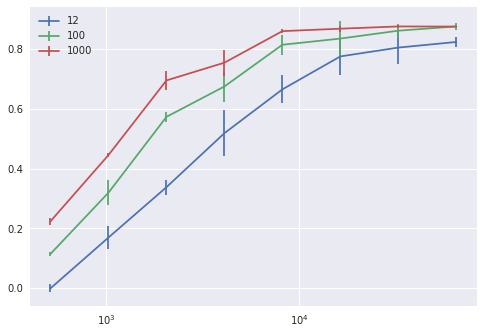

In [28]:
# chose best regularization from cross validation
#rep,Data,reg,N,model/mean
Data = 2**np.arange(9,17)
D=len(Data)
Neurons=[12,100,1000]
ind_r = []
ind_m = []
fev_best = []
for n in range(len(Neurons)):
    N=Neurons[n]
    repetitions = VAL[n].shape[0]
    ind_r.append(np.zeros([repetitions,D,N]))
    ind_m.append(np.zeros([repetitions,D,3,N]))
    fev_best.append(np.zeros([repetitions,D,N]))
    for rep in range(repetitions):
        for d in range(D):
            #best reg?
            for i in range(N):
                ind_r[n][rep,d,i] = np.argmin(np.min(VAL[n][rep,d,:,i,:],-1))
                #model or mean?
                for r in range(3):
                    ind_m[n][rep,d,r,i] = np.argmin(VAL[n][rep,d,r,i,:])
                
                #choose best reg and model/mean for all units and reps
                fev_best[n][rep,d,i] = FEV[n][rep,d,
                               np.int(ind_r[n][rep,d,i]),i,
                               np.int(ind_m[n][rep,d,np.int(ind_r[n][rep,d,i]),i])]
                
#take c1000 with different reg:
run = np.load('CNN-1000_extraA.npz')
Val_c1000_others=run['Val_c1000']
FEV_c1000_others=run['FEV_c1000']#reps,data,N,2
data_ind=[0,5]
for rep in range(fev_best[-1].shape[0]):
    for d in range(len(data_ind)):
        #model or mean?
        for i in range(1000):
            tmp_ind = np.argmin(Val_c1000_others[rep,d,i,:])
                
            fev_best[-1][rep,data_ind[d],i] = FEV_c1000_others[rep,d,i,np.int(tmp_ind)]
            
#take other reruns
run = np.load('CNN-1000_extraB_AND_CNN-12_extraA.npz')
Val_c12=run['Val_c12']
FEV_c12=run['FEV_c12']#reps,data,N,2
Val_c1000=run['Val_c1000']
FEV_c1000=run['FEV_c1000']#reps,data,N,2

repetitions = fev_best[0].shape[0]
ind_m12 = np.zeros([repetitions,9,12])
ind_r12 = np.zeros([repetitions,12])
for rep in range(repetitions):
    for i in range(12):
        ind_r12[rep,i] = np.argmin(np.min(Val_c12[rep,1,:,i,:],-1))
        for r in range(9):
            ind_m12[rep,r,i] = np.argmin(Val_c12[rep,1,r,i,:])
        fev_best[0][rep,-1,i] = FEV_c12[rep,1,
                                   np.int(ind_r12[rep,i]),i,
                                   np.int(ind_m12[rep,np.int(ind_r12[rep,i]),i])]

repetitions = fev_best[-1].shape[0]
ind_m1000 = np.zeros([repetitions,2,9,1000])
ind_r1000 = np.zeros([repetitions,2,1000])
for rep in range(repetitions):
    for i in range(1000):
        ind_r1000[rep,0,i] = np.argmin(np.min(Val_c1000[rep,0,:,i,:],-1))
        ind_m1000[rep,0,r,i] = np.argmin(Val_c1000[rep,0,r,i,:])
        fev_best[-1][rep,-2,i] = FEV_c1000[rep,0,
                                   np.int(ind_r1000[rep,0,i]),i,
                                   np.int(ind_m1000[rep,0,np.int(ind_r1000[rep,0,i]),i])]
    for i in range(1000):
        ind_r1000[rep,1,i] = np.argmin(np.min(Val_c1000[rep,1,:,i,:],-1))
        ind_m1000[rep,1,r,i] = np.argmin(Val_c1000[rep,1,r,i,:])
        fev_best[-1][rep,-1,i] = FEV_c1000[rep,1,
                                   np.int(ind_r1000[rep,1,i]),i,
                                   np.int(ind_m1000[rep,1,np.int(ind_r1000[rep,1,i]),i])]
                    
#now look at performance over repetitions
for n in range(3):
    N=2**(n+2)*64
    fev_m = np.zeros(D)
    fev_sd = np.zeros(D)
    for d in range(D):
        fev_m[d] = np.mean(np.mean(fev_best[n][:,d,:],-1))#mean over reps for each neuron, then mean over neurons
        fev_sd[d] = np.std(np.mean(fev_best[n][:,d,:],-1))#mean over reps for each neuron, then std over neurons
        
    plt.errorbar(Data,fev_m,fev_sd)
plt.gca().set_xscale("log", nonposx='clip')
plt.legend(Neurons)
plt.show()

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


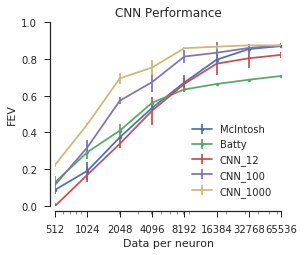

In [29]:
# MCint and Batty
sns.set(font_scale=1)  # crazy big
sns.set_style('ticks')
fig_size = np.array([6,5])/2.54*12/7#like fig2 comparison
fig, ax = plt.subplots(figsize=fig_size)
ax = plt.subplot(1,1,1)

reps = 3
tmp = np.load('./Batty_fit.npz')
fev_batty = tmp['FEV']#reps x data
val_batty = tmp['Val']
tmp2 = np.load('./McIntosh_fit.npz')
fev_mcint_raw = tmp2['FEV']#reps x data x reg
val_mcint = tmp2['Val']

fev_mcint = np.zeros([reps,D])
for r in range(reps):
    for d in range(D):
        fev_mcint[r,d] = fev_mcint_raw[r,d,np.argmin(val_mcint[r,d,:])]

batty_m = np.zeros(D)
batty_sd = np.zeros(D)
mcint_m = np.zeros(D)
mcint_sd = np.zeros(D)

for d in range(D):
    batty_m[d] = np.mean(fev_batty[:,d])
    batty_sd[d] = np.std(fev_batty[:,d])
    mcint_m[d] = np.mean(fev_mcint[:,d])
    mcint_sd[d] = np.std(fev_mcint[:,d])
plt.errorbar(Data,mcint_m,mcint_sd,marker='.')
plt.errorbar(Data,batty_m,batty_sd,marker='.')

#Ours
for n in range(3):
    N=2**(n+2)*64
    fev_m = np.zeros(D)
    fev_sd = np.zeros(D)
    for d in range(D):
        fev_m[d] = np.mean(np.mean(fev_best[n][:,d,:],-1))#mean over reps for each neuron, then mean over neurons
        fev_sd[d] = np.std(np.mean(fev_best[n][:,d,:],-1))#mean over reps for each neuron, then std over neurons
        
    plt.errorbar(Data,fev_m,fev_sd)
    
ax.set_xlabel('Data per neuron')
ax.set_ylabel('FEV')
ax.set_xscale("log", nonposx='clip')
ax.set_xticks(Data)#[::2])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.title('CNN Performance')
plt.legend(['McIntosh','Batty','CNN_12','CNN_100','CNN_1000'])
ax.set_xlim([512,2**16])
ax.set_ylim([0,1])
sns.despine(offset=5,trim=True)
#plt.gcf().savefig('fig5b_final.pdf')
plt.show()
sns.reset_orig()
